<a href="https://colab.research.google.com/github/SETIADEEPANSHU/ExtensiveVisionAIProgramme/blob/master/Session_9_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GRAD CAM Class Activation Maps
When training image classifiers, you wish to know that it generates predictions based on what you want the model to see




In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
! pip install wandb
! wandb login c5bf53419ae0f4e50a29f8d29ec0ef37689027df


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [5]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="session-8a")

W&B Run: https://app.wandb.ai/univai-ss2019/session-8a/runs/xcx4uova

In [0]:
import os 

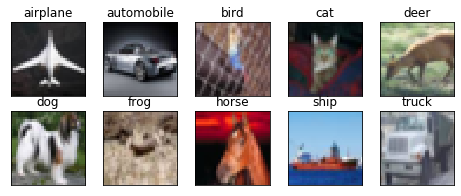

In [7]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


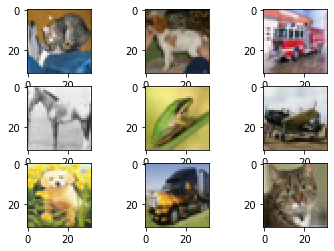

In [8]:
# example of loading the cifar10 dataset
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# Numbers to visualize
indices_to_visualize = [ 0, 12, 38, 83, 112, 74, 190 , 225, 336]
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
pos = 0
for i in indices_to_visualize:
    # define subplot
    pyplot.subplot(330 + 1 + pos)
    # plot raw pixel data
    pyplot.imshow(testX[i])
    pos += 1
# show the figure
pyplot.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Images must be Z-score (mean-std) normalized because that’s how we have implemented while training also. Z-score normalization is important because it results in similarly-ranged feature values and that the gradients don’t go out of control (need one global learning rate multiplier).

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# mean-std normalization
mean = np.mean(train_features,axis=(0,1,2,3))
std = np.std(train_features,axis=(0,1,2,3))
train_features = (train_features-mean)/(std+1e-7)
test_features = (test_features-mean)/(std+1e-7)

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [12]:
from keras import regularizers
# Define the model
weight_decay = 1e-4
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(48, 3, 3, ))
#model.add(Convolution2D(48, 1))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) # dropout 20%
model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3, ))
#model.add(Convolution2D(96, 1))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3)) # dropout 30%
model.add(Convolution2D(192, 3, 3,border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3, name='visualized_layer'))
#model.add(Convolution2D(192, 1))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40)) # dropout 40%
model.add(Convolution2D(10, 2))
model.add(Flatten())
#model.add(Dense(512))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(256))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
#model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#rmspop = optimizers.RMSprop(lr=0.001, rho=0.9)
#model.compile(optimizer=rmspop, loss='categorical_crossentropy', metrics=['accuracy'])
#adamax = optimizers.Adamax()
#model.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])
#nadam = optimizers.Nadam()
#model.compile(optimizer=nadam, loss='categorical_crossentropy', metrics=['accuracy'])

#wandb.init(name="BN > RELU > MXP > DO")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  """








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), name="visualized_layer")`


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 48)        192       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)       

In keras, fit() is much similar to sklearn's fit method, where you pass array of features as x values and target as y values. You pass your whole dataset at once in fit method. Also, use it if you can load whole data into your memory (small dataset).

In fit_generator(), you don't pass the x and y directly, instead they come from a generator. As it is written in keras documentation, generator is used when you want to avoid duplicate data when using multiprocessing. This is for practical purpose, when you have large dataset.

A thing you should know about Keras if you plan to train a deep learning model on a large dataset:
https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<wandb.ke..., steps_per_epoch=390, epochs=20)`
  app.launch_new_instance()




Epoch 1/20
390/390 [==============================] - 12s 32ms/step - loss: 1.6027 - acc: 0.4610 - val_loss: 1.1981 - val_acc: 0.5824
Epoch 2/20
390/390 [==============================] - 8s 20ms/step - loss: 1.0212 - acc: 0.6406 - val_loss: 0.8596 - val_acc: 0.6986
Epoch 3/20
390/390 [==============================] - 8s 20ms/step - loss: 0.8160 - acc: 0.7131 - val_loss: 0.7383 - val_acc: 0.7417
Epoch 4/20
390/390 [==============================] - 8s 20ms/step - loss: 0.7013 - acc: 0.7554 - val_loss: 0.6784 - val_acc: 0.7696
Epoch 5/20
390/390 [==============================] - 8s 20ms/step - loss: 0.6242 - acc: 0.7848 - val_loss: 0.6780 - val_acc: 0.7654
Epoch 6/20
390/390 [==============================] - 8s 20ms/step - loss: 0.5663 - acc: 0.8017 - val_loss: 0.5664 - val_acc: 0.8045
Epoch 7/20
390/390 [==============================] - 8s 21ms/step - loss: 0.5132 - acc: 0.8196 - val_loss: 0.5579 - val_acc: 0.8073
Epoch 8/20
390/390 [==============================] - 8s 21ms/step

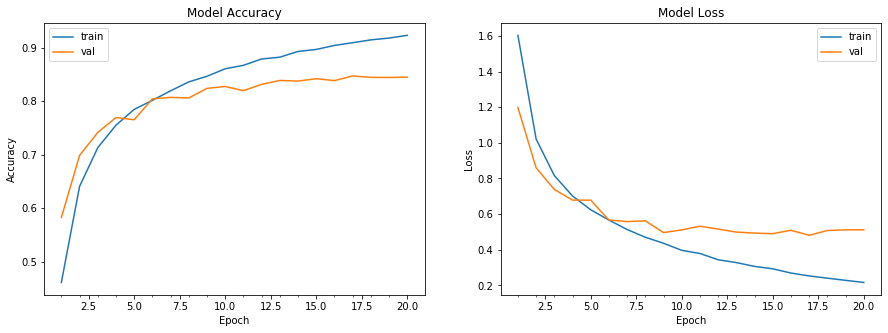

Accuracy on test data is: 84.52


In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, horizontal_flip=False)

#datagen = ImageDataGenerator(zca_whitening=True)
#datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

from keras.callbacks import EarlyStopping
#callbacks = [EarlyStopping(monitor='val_acc', patience=2)]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[WandbCallback()])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [15]:
!pip install https://github.com/raghakot/keras-vis/archive/master.zip

     \ 57.9MB 7.1MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30856 sha256=88990dee13c8c60d5efd8ad0fd284a9756547a19fb2716c17dc51baafb68c0bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdcpqh3a/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [0]:
# =============================================
# Grad-CAM code
# =============================================
from vis.visualization import visualize_cam, overlay
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [17]:
# Find the index of the to be visualized layer above
layer_index = utils.find_layer_idx(model, 'visualized_layer')
print(layer_index)

17


In [0]:
from keras import activations
# Swap softmax with linear
model.layers[layer_index].activation = activations.linear
model = utils.apply_modifications(model)  

In [0]:
# Numbers to visualize
indices_to_visualize = [ 0, 12, 38, 83, 112, 74, 190 , 225, 336]

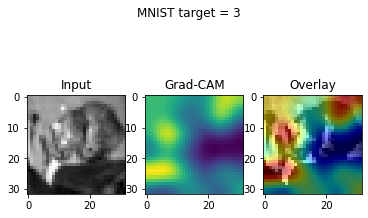

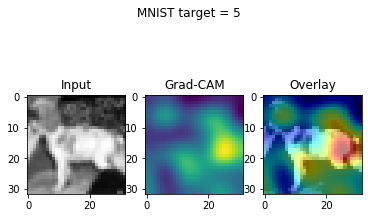

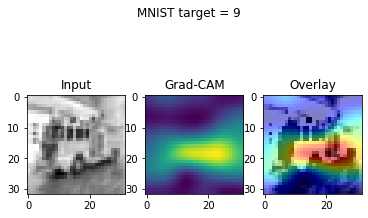

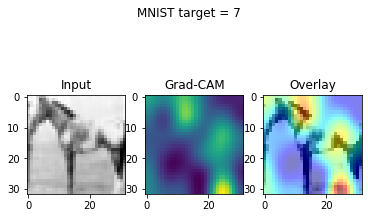

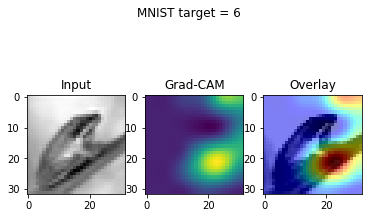

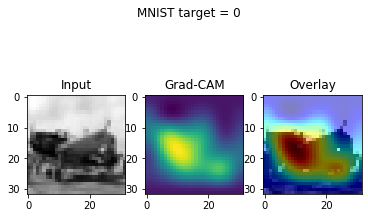

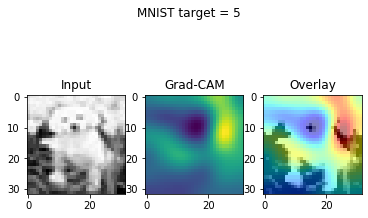

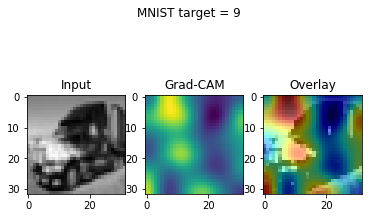

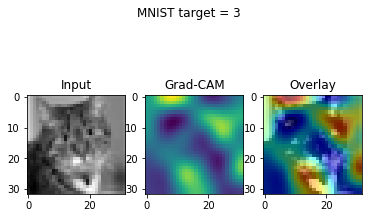

In [20]:
# Visualize
for index_to_visualize in indices_to_visualize:
  # Get input
  input_image = test_features[index_to_visualize]
  input_class = np.argmax(test_labels[index_to_visualize])
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  # Generate visualization
  visualization = visualize_cam(model, layer_index, filter_indices=input_class, seed_input=input_image)
  axes[0].imshow(input_image[..., 0], cmap='gray') 
  axes[0].set_title('Input')
  axes[1].imshow(visualization)
  axes[1].set_title('Grad-CAM')
  heatmap = np.uint8(cm.jet(visualization)[..., :3] * 255)
  original = np.uint8(cm.gray(input_image[..., 0])[..., :3] * 255)
  axes[2].imshow(overlay(heatmap, original))
  axes[2].set_title('Overlay')
  fig.suptitle(f'MNIST target = {input_class}')
  plt.show()